In [19]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

In [20]:
# Chargement des données
df = pd.read_excel('data/Base_ISM_PARIS_301224.xlsx')

In [21]:
# Afficher les premières lignes pour vérifie
df.head()

,hh1,hh2,a0,pond,strate,milieu,b05_region,f1,f0,g1,...,ep,v02new,education,diplome,age,deplog,depalim,bien,depenseM,P0
0,1,1,1,649.757758,ville d'Abidjan,Urbain,district autonome d'abidjan,non,NaN,non,...,Emploi permanent,Abidjan,aucun,0,38,414000.0,1.280935e+06,0.0,2268735.00,Non pauvre
1,1,2,1,860.465088,ville d'Abidjan,Urbain,district autonome d'abidjan,non,NaN,non,...,NaN,Abidjan,superieur,deug/dues/duel,24,354500.0,8.162167e+05,0.0,1655716.75,Non pauvre
2,1,3,1,789.849333,ville d'Abidjan,Urbain,district autonome d'abidjan,non,NaN,non,...,Emploi permanent,Abidjan,aucun,0,28,399500.0,7.818000e+05,0.0,1719700.00,Non pauvre
3,1,4,1,712.474380,ville d'Abidjan,Urbain,district autonome d'abidjan,non,NaN,non,...,Emploi permanent,Abidjan,superieur,deug/dues/duel,40,482000.0,7.367000e+05,0.0,2227500.00,Non pauvre
4,1,5,1,789.849333,ville d'Abidjan,Urbain,district autonome d'abidjan,non,NaN,non,...,Emploi permanent,Abidjan,secondaire,bepc,27,419000.0,3.600000e+05,NaN,1027400.00,Non pauvre


# Exploration de données

In [22]:
# Information générale
print(df.info())
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12899 entries, 0 to 12898
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hh1         12899 non-null  int64  
 1   hh2         12899 non-null  int64  
 2   a0          12899 non-null  int64  
 3   pond        12899 non-null  float64
 4   strate      12899 non-null  object 
 5   milieu      12899 non-null  object 
 6   b05_region  12899 non-null  object 
 7   f1          12899 non-null  object 
 8   f0          2659 non-null   float64
 9   g1          12899 non-null  object 
 10  h1          12899 non-null  object 
 11  hhsize      12899 non-null  int64  
 12  a1          12899 non-null  object 
 13  gage        12899 non-null  object 
 14  a5          12899 non-null  object 
 15  a6_ethpays  12899 non-null  object 
 16  a7          12899 non-null  object 
 17  a8a         12899 non-null  object 
 18  a9a         12899 non-null  object 
 19  a10a        12899 non-nul

In [23]:
# Vérification des valeurs manquantes
missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]
print(missing_values)

f0           10240
cq25         12794
popemp           8
secteur       2852
sectinst      2852
ep            3897
education      102
depalim         47
bien           624
dtype: int64


In [24]:
df['f0'] = df['f0'].fillna(0)
df['bien'] = df['bien'].fillna(df['bien'].median())
df['education'] = df['education'].fillna('non renseigné')
df['sectinst'] = df['sectinst'].fillna('non renseigné')
df['secteur'] = df['secteur'].fillna('non renseigné')
df['popemp'] = df['popemp'].fillna('non renseigné')
df['ep'] = df['ep'].fillna('non renseigné')
df['depalim'] = df['depalim'].fillna(df['depalim'].median())
df['cq25'] = df['cq25'].fillna(df['cq25'].mode()[0]) 

# Vérification après traitement des valeurs manquantes
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


In [25]:
# Conversion des colonnes float en int
df[df.select_dtypes('float').columns] = df.select_dtypes('float').astype(int)
print(df.dtypes)

hh1            int64
hh2            int64
a0             int64
pond           int64
strate        object
milieu        object
b05_region    object
f1            object
f0             int64
g1            object
h1            object
hhsize         int64
a1            object
gage          object
a5            object
a6_ethpays    object
a7            object
a8a           object
a9a           object
a10a          object
a11a          object
a12a          object
cq1a          object
cq2a          object
cq4           object
cq18a         object
cq19a         object
cq20a         object
cq21a         object
cq22a         object
cq23a         object
cq24a         object
cq25          object
dq1           object
dq3           object
dq4           object
ja1           object
ja4           object
ja6           object
popemp        object
secteur       object
sectinst      object
ep            object
v02new        object
education     object
diplome       object
age            int64
deplog       

## Visualisation

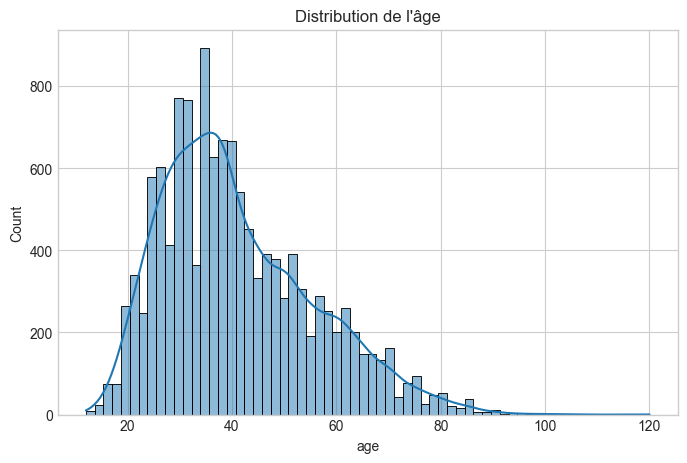

In [26]:
# Distribution de l'âge
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], kde=True)
plt.title("Distribution de l'âge")
plt.show()

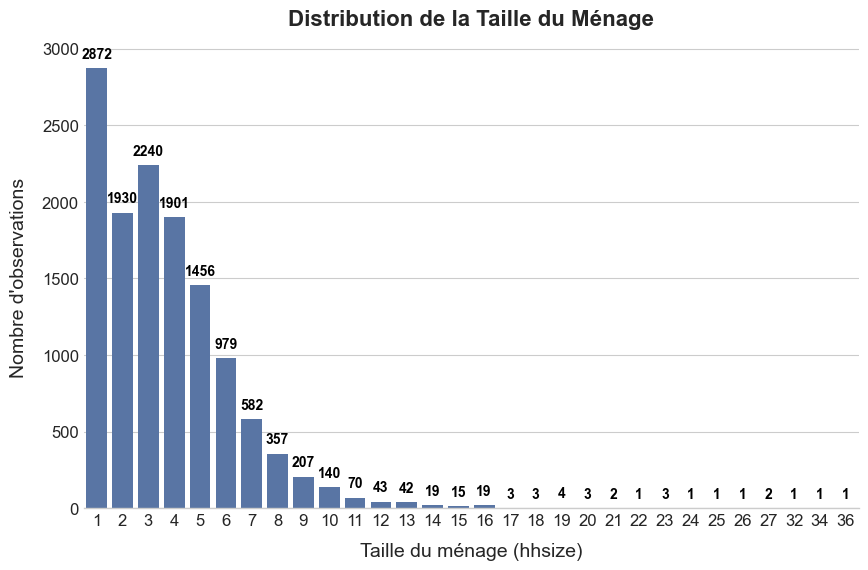

In [27]:
# Distribution de la Taille du Ménage
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 6))
sorted_hhsize = sorted(df['hhsize'].unique())
ax = sns.countplot(data=df, x='hhsize', order=sorted_hhsize, color="#4C72B0")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold', xytext=(0, 5), textcoords='offset points')
plt.title("Distribution de la Taille du Ménage", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Taille du ménage (hhsize)", fontsize=14, labelpad=10)
plt.ylabel("Nombre d'observations", fontsize=14, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)
plt.show()

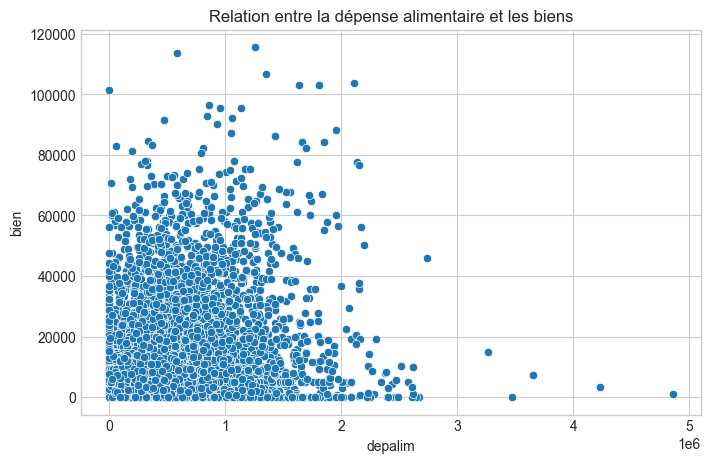

In [28]:
# Relation entre deux variables( depalim vs bien)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='depalim', y='bien', data=df)
plt.title("Relation entre la dépense alimentaire et les biens")
plt.show()

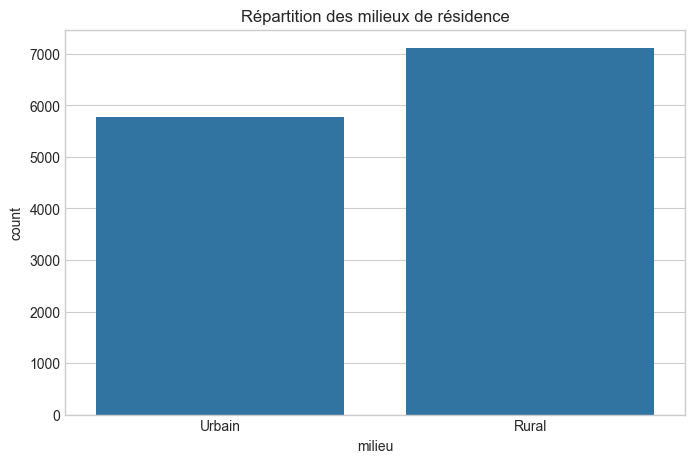

In [29]:
# Répartition des milieux de résidence
plt.figure(figsize=(8, 5))
sns.countplot(x='milieu', data=df)
plt.title("Répartition des milieux de résidence")
plt.show()

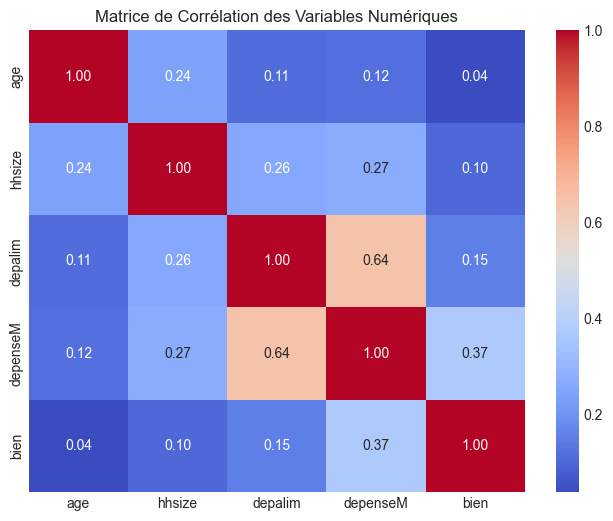

In [30]:
# Matrice de corrélation pour les variables numériques
numeric_vars = ['age', 'hhsize', 'depalim', 'depenseM', 'bien']
corr_matrix = df[numeric_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation des Variables Numériques")
plt.show()


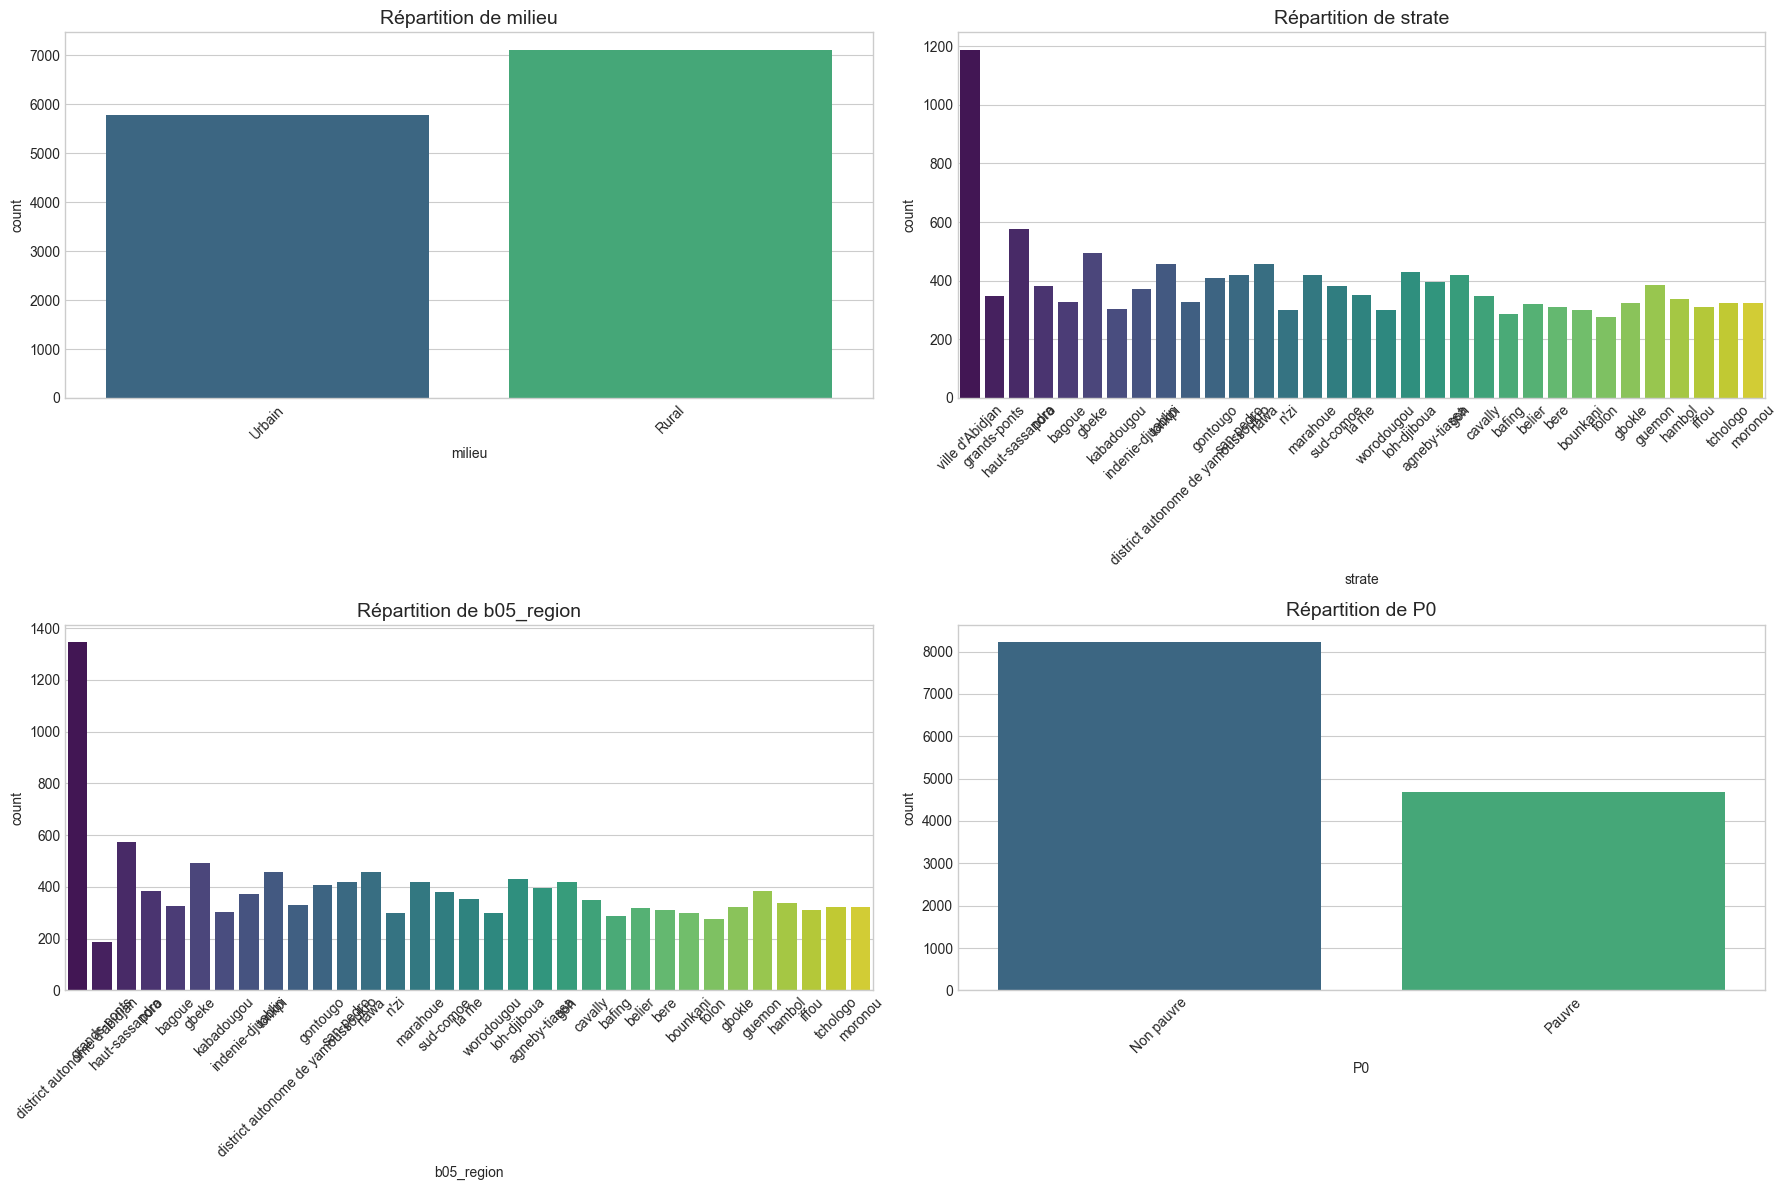

In [31]:
categorical_vars = ['milieu', 'strate', 'b05_region', 'P0']
plt.figure(figsize=(18, 12))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    
    sns.countplot(data=df, x=var, hue=var, palette="viridis", legend=False)
    plt.title(f"Répartition de {var}", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

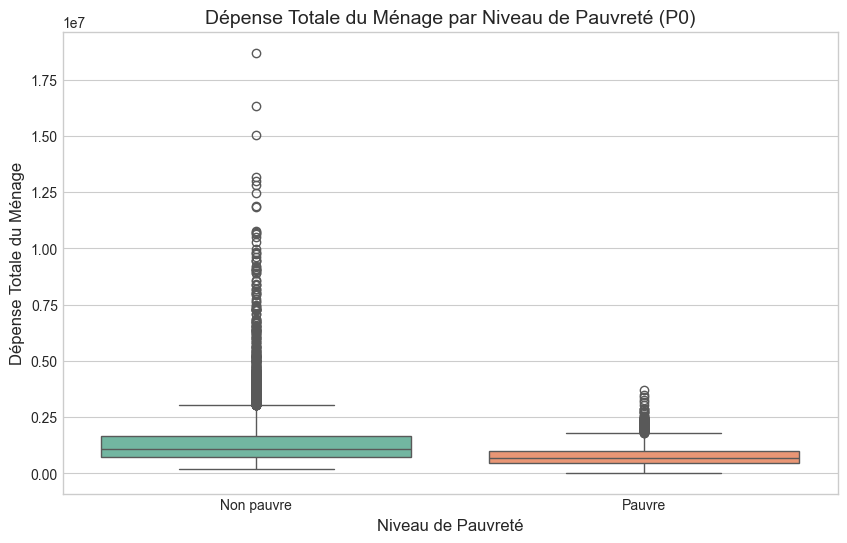

In [32]:
# Relations entre variables (Dépense Totale du Ménage par Niveau de Pauvreté)
plt.figure(figsize=(10, 6))

sns.boxplot(x='P0', y='depenseM', data=df, hue='P0', palette="Set2", dodge=False, legend=False)

plt.title("Dépense Totale du Ménage par Niveau de Pauvreté (P0)", fontsize=14)
plt.xlabel("Niveau de Pauvreté", fontsize=12)
plt.ylabel("Dépense Totale du Ménage", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

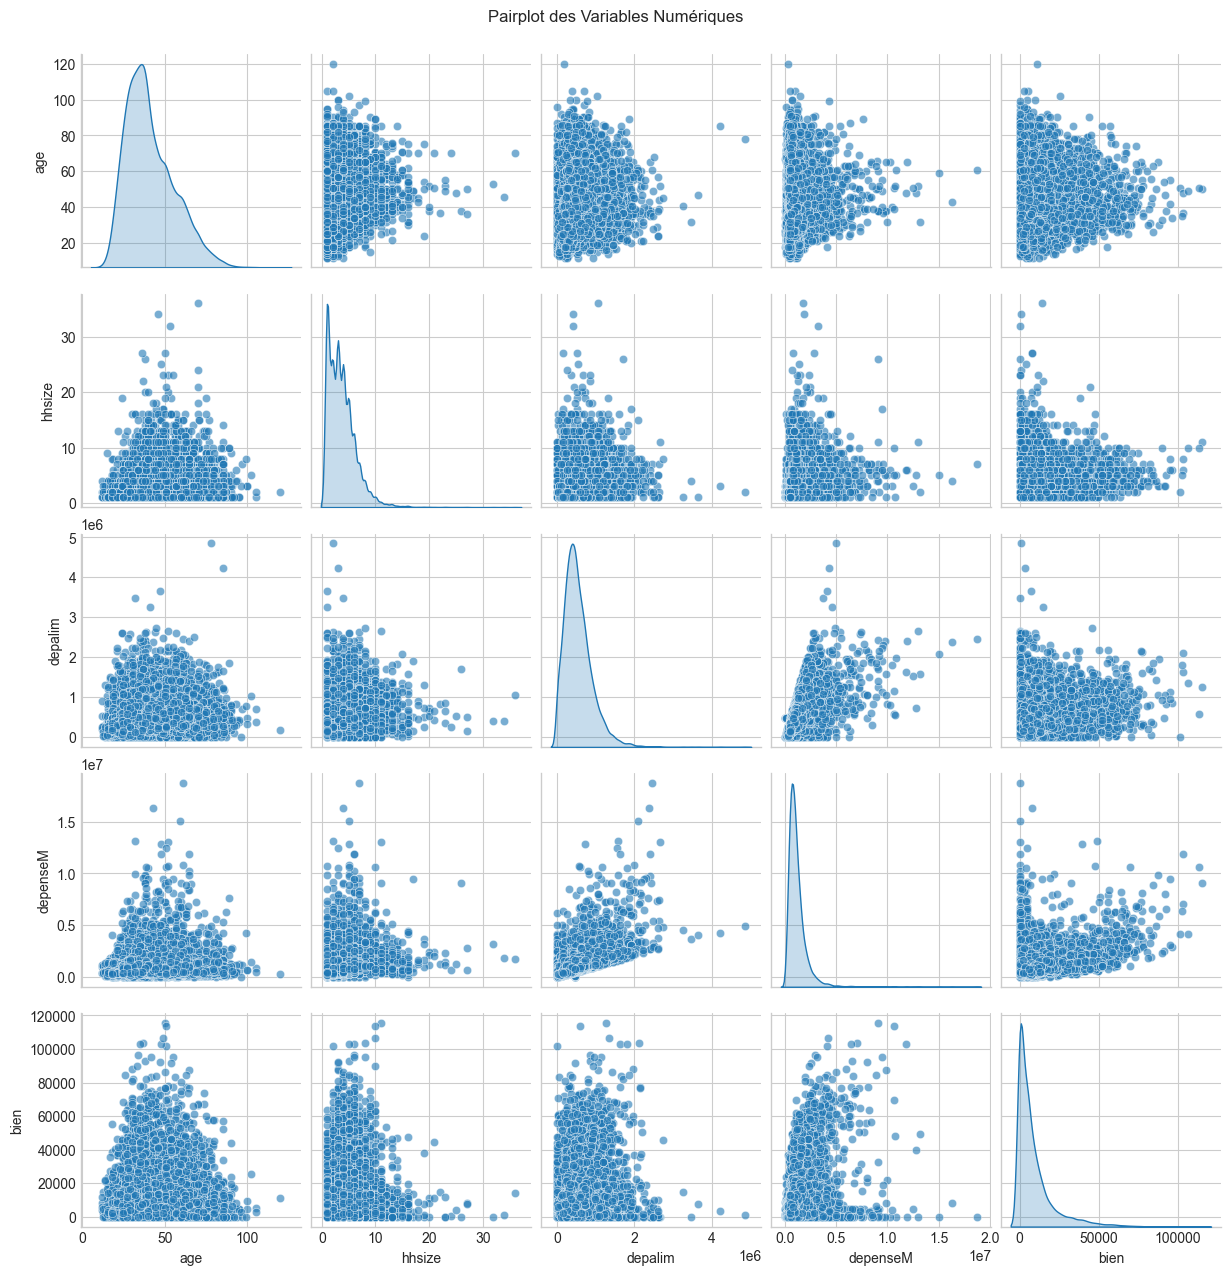

In [33]:
# Analyse bivariée avec des Variables Numériques
sns.pairplot(df[numeric_vars], diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot des Variables Numériques", y=1.02)
plt.show()


In [34]:
# Identifier les colonnes non numériques
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

binary_columns = [col for col in categorical_columns if df[col].nunique(dropna=True) == 2]
multi_columns = [col for col in categorical_columns if df[col].nunique(dropna=True) > 2]

print("Colonnes binaires sélectionnées :", binary_columns)
print("Colonnes catégorielles multinomiales sélectionnées :", multi_columns)

Colonnes binaires sélectionnées : ['milieu', 'f1', 'h1', 'a1', 'a6_ethpays', 'a8a', 'a9a', 'a10a', 'a11a', 'a12a', 'cq1a', 'cq2a', 'cq4', 'cq18a', 'cq19a', 'cq20a', 'cq21a', 'cq22a', 'cq23a', 'cq24a', 'cq25', 'dq4', 'ja1', 'ja4', 'ja6', 'P0']
Colonnes catégorielles multinomiales sélectionnées : ['strate', 'b05_region', 'g1', 'gage', 'a5', 'a7', 'dq1', 'dq3', 'popemp', 'secteur', 'sectinst', 'ep', 'v02new', 'education', 'diplome']


In [35]:
# Encodage
# 1. Label Encoding pour les variables binaires
label_encoder = LabelEncoder()
for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])

# 2. One-Hot Encoding pour les variables à plusieurs catégories
df_encoded = pd.get_dummies(df, columns=multi_columns, drop_first=True)
print(df_encoded.head())

   hh1  hh2  a0  pond  milieu  f1  f0  h1  hhsize  a1  ...  diplome_cepe  \
0    1    1   1   649       1   0   0   0       2   1  ...         False   
1    1    2   1   860       1   0   0   0       3   1  ...         False   
2    1    3   1   789       1   0   0   0       2   1  ...         False   
3    1    4   1   712       1   0   0   0       5   1  ...         False   
4    1    5   1   789       1   0   0   0       2   1  ...         False   

   diplome_dea  diplome_dess  diplome_deug/dues/duel  diplome_doctorat  \
0        False         False                   False             False   
1        False         False                    True             False   
2        False         False                   False             False   
3        False         False                    True             False   
4        False         False                   False             False   

   diplome_dut  diplome_ingénieur  diplome_licence  diplome_maitrise  \
0        False            

In [36]:
# Normalisation
# Identifier les colonnes numériques dans le DataFrame encodé
numeric_columns_encoded = [col for col in df_encoded.columns if col != 'P0' and np.issubdtype(df_encoded[col].dtype, np.number)]

# Appliquer la normalisation uniquement aux colonnes numériques
if numeric_columns_encoded:
    scaler = StandardScaler()
    df_encoded[numeric_columns_encoded] = scaler.fit_transform(df_encoded[numeric_columns_encoded])

print("Données après normalisation :")
print(df_encoded.head())


Données après normalisation :
        hh1       hh2   a0      pond    milieu        f1        f0        h1  \
0 -1.730573 -1.593197  0.0  0.513618  1.109107 -0.509576 -0.478327 -0.858626   
1 -1.730573 -1.303507  0.0  1.128263  1.109107 -0.509576 -0.478327 -0.858626   
2 -1.730573 -1.013816  0.0  0.921440  1.109107 -0.509576 -0.478327 -0.858626   
3 -1.730573 -0.724125  0.0  0.697138  1.109107 -0.509576 -0.478327 -0.858626   
4 -1.730573 -0.434435  0.0  0.921440  1.109107 -0.509576 -0.478327 -0.858626   

     hhsize        a1  ...  diplome_cepe  diplome_dea  diplome_dess  \
0 -0.651852  0.494324  ...         False        False         False   
1 -0.266806  0.494324  ...         False        False         False   
2 -0.651852  0.494324  ...         False        False         False   
3  0.503284  0.494324  ...         False        False         False   
4 -0.651852  0.494324  ...         False        False         False   

   diplome_deug/dues/duel  diplome_doctorat  diplome_dut  dipl

In [37]:
# Vérifier que P0 est toujours discrète
print("Types de données après normalisation :")
print(df_encoded.dtypes)

# Vérifier les valeurs uniques de P0
print("Valeurs uniques de P0 :", df_encoded['P0'].unique())

Types de données après normalisation :
hh1                   float64
hh2                   float64
a0                    float64
pond                  float64
milieu                float64
                       ...   
diplome_dut              bool
diplome_ingénieur        bool
diplome_licence          bool
diplome_maitrise         bool
diplome_mba/master       bool
Length: 178, dtype: object
Valeurs uniques de P0 : [0 1]


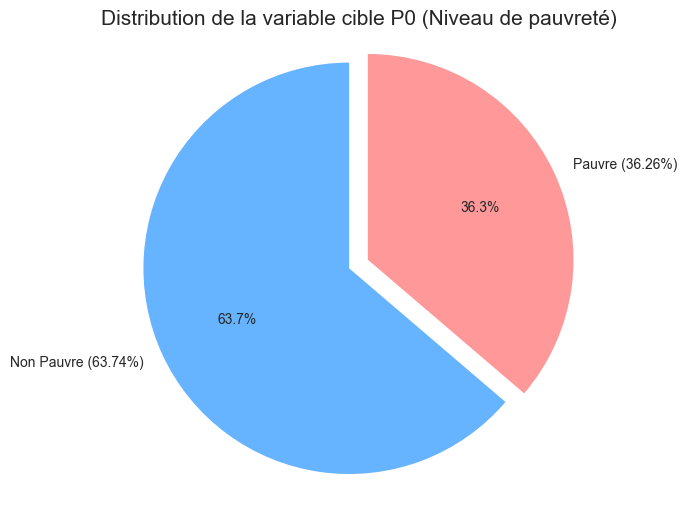

Proportions des classes dans P0 :
P0
0    63.74
1    36.26
Name: proportion, dtype: float64


In [38]:
# Distribution de la variable cible
class_counts = df['P0'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))

plt.pie(class_counts, labels=[f"Non Pauvre ({class_counts[0]*100:.2f}%)", f"Pauvre ({class_counts[1]*100:.2f}%)"], 
        autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff9999"], explode=(0.1, 0))  

plt.title('Distribution de la variable cible P0 (Niveau de pauvreté)', fontsize=15)

plt.axis('equal')  
plt.show()

print("Proportions des classes dans P0 :")
print(round(class_counts*100,2))

In [39]:


X = df_encoded.drop(columns=["P0"])
y = df_encoded["P0"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application de SMOTE pour équilibrer les classes dans l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


class_counts_smote = y_train_res.value_counts()

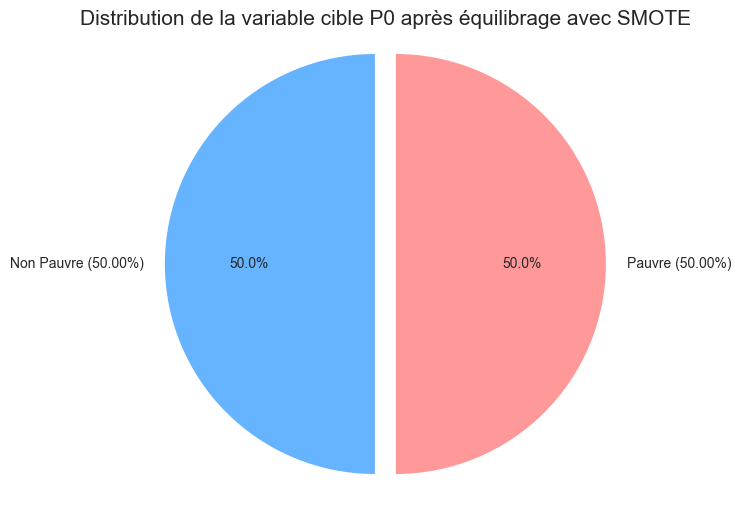

Proportions des classes dans P0 après SMOTE :
P0
1    0.5
0    0.5
Name: count, dtype: float64


In [40]:
# Distribution de la variable cible
plt.figure(figsize=(8, 6))


plt.pie(class_counts_smote, labels=[f"Non Pauvre ({class_counts_smote[0]*100/len(y_train_res):.2f}%)", f"Pauvre ({class_counts_smote[1]*100/len(y_train_res):.2f}%)"], 
        autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff9999"], explode=(0.1, 0)) 

plt.title('Distribution de la variable cible P0 après équilibrage avec SMOTE', fontsize=15)

plt.axis('equal') 
plt.show()

# Afficher les proportions des classes dans l'ensemble d'entraînement après SMOTE
print("Proportions des classes dans P0 après SMOTE :")
print(class_counts_smote / len(y_train_res))  # Calcul des proportions

In [41]:
# Initialisation des modèles avec des paramètres adaptés
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),  # Augmenter max_iter et changer le solver
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

In [42]:
# Stocker les résultats des performances
results = {}
best_model = None
best_f1_score = 0

In [43]:
# Entraînement et évaluation de chaque modèle
for model_name, model in models.items():
    print(f"Entraînement du modèle : {model_name}")
    
    try:
        # Entraîner le modèle
        model.fit(X_train_res, y_train_res)
        
        # Faire des prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculer les métriques
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
        
        # Stocker les résultats
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        }
        
        # Sélectionner le meilleur modèle basé sur le F1 Score
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model = model_name
            best_model_instance = model
    
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle {model_name} : {e}")

Entraînement du modèle : Logistic Regression
Entraînement du modèle : Decision Tree
Entraînement du modèle : Random Forest
Entraînement du modèle : SVM


In [44]:
# Afficher les résultats
results_df = pd.DataFrame(results).T
print("Résultats des modèles :")
print(results_df)

print(f"\nMeilleur modèle : {best_model} (F1 Score : {best_f1_score})")

Résultats des modèles :
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.976357   0.962596  0.970067  0.966317  0.998282
Decision Tree        0.980620   0.969163  0.975610  0.972376  0.979462
Random Forest        0.936434   0.920273  0.895787  0.907865  0.983585
SVM                  0.936822   0.914703  0.903548  0.909091  0.987557

Meilleur modèle : Decision Tree (F1 Score : 0.9723756906077348)


In [45]:
# Réoptimisation des hyperparamètres pour le meilleur modèle
if best_model == "Logistic Regression":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }
elif best_model == "Decision Tree":
    param_grid = {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }
elif best_model == "SVM":
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

In [46]:

# Optimisation avec GridSearchCV (si applicable)
if param_grid: 
    print(f"Optimisation des hyperparamètres pour {best_model}...")
    grid_search = GridSearchCV(best_model_instance, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)
    best_model_instance = grid_search.best_estimator_
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

Optimisation des hyperparamètres pour Decision Tree...
Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [47]:
import os
import pandas as pd
import numpy as np

# Vérifier si le dossier trained_model existe, sinon le créer
if not os.path.exists("trained_model"):
    os.makedirs("trained_model")

# Sélection des variables importantes (si possible)
if isinstance(best_model_instance, (RandomForestClassifier, LogisticRegression)):
    if hasattr(best_model_instance, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model_instance.feature_importances_
        }).sort_values(by='Importance', ascending=False)
    elif hasattr(best_model_instance, 'coef_'):
        feature_importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.abs(best_model_instance.coef_[0])
        }).sort_values(by='Importance', ascending=False)
    
    # Sélectionner les variables importantes (par exemple, Importance > moyenne)
    selected_features = feature_importances[feature_importances['Importance'] > feature_importances['Importance'].mean()]['Feature'].tolist()
    print(f"Variables retenues : {selected_features}")
else:
    # Si le modèle ne fournit pas d'importance des variables, garder toutes les variables
    selected_features = X.columns.tolist()
    print("Le modèle ne fournit pas d'importance des variables. Toutes les variables sont conservées.")

# Créer un DataFrame contenant les features sélectionnées
features_df = pd.DataFrame(selected_features, columns=["Selected_Features"])

# Chemin du fichier Excel dans le dossier trained_model
features_excel_path = os.path.join("trained_model", "selected_features.xlsx")

# Sauvegarder les features dans un fichier Excel
features_df.to_excel(features_excel_path, index=False)

print(f"Noms des features sauvegardés dans : {features_excel_path}")

Le modèle ne fournit pas d'importance des variables. Toutes les variables sont conservées.
Noms des features sauvegardés dans : trained_model\selected_features.xlsx


In [48]:
# Créer un pipeline final avec les variables sélectionnées
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

pipeline_final = Pipeline(steps=[
    ('selector', SelectFromModel(best_model_instance, threshold="mean")) if len(selected_features) < len(X.columns) else ('passthrough', 'passthrough'),
    ('classifier', best_model_instance)
])

In [49]:
# Entraîner le pipeline final
if len(selected_features) < len(X.columns):
    pipeline_final.fit(X_train_res[selected_features], y_train_res)
else:
    pipeline_final.fit(X_train_res, y_train_res)

In [50]:
# Évaluer le pipeline final
y_pred_final = pipeline_final.predict(X_test[selected_features] if len(selected_features) < len(X.columns) else X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print(f"Performance du pipeline final - Accuracy : {accuracy_final}, F1 Score : {f1_final}")

Performance du pipeline final - Accuracy : 0.9771317829457364, F1 Score : 0.9674213141910547


In [51]:
# Sauvegarder le modèle dans le dossier trained_model
model_path = os.path.join("trained_model", "final_model.pkl")
joblib.dump(pipeline_final, model_path)

print(f"Modèle final sauvegardé à : {model_path}")

Modèle final sauvegardé à : trained_model\final_model.pkl
